### Nous allons prendre quelques données de la phase 1 et ajouter à celles de la phase 2 tout en essayant d'avoir un rapport 1/10 et 9/10 entre les classes 

En plus claire voici l'algorithme que nous suivons: 

- Concatener tous les articles de la phase 1 et ceux de la phase 2
- Conserver les articles de types VS tels qu'ils sont, conserver aussi les NVS de la phase 2
- Piocher dans les articles de la phase 1 (considérés comme NVS) une quantité qui aidera à avoir une proportion 1/10 de VS et 9/10 de NVS 

In [47]:
import pandas as pd 

# les données de la phase 1
data1 = pd.read_csv("data/articles_selectionnes_umap_et_kmeans.csv", keep_default_na=False)

# les données de la phase 2
data2 = pd.read_csv("data/articles_SA&SV.csv", keep_default_na=False)


On va conserver les articles VS que nous avons eu à la phase 2

In [58]:
data1.columns

Index(['title', 'text', 'thematique', 'Maladie', 'text_sans_html',
       'text_concat', 'clean_text', 'x', 'y', 'z', 'cluster', 'dist'],
      dtype='object')

In [2]:
data2.columns

Index(['url', 'title', 'text', 'type_article', 'thematique', 'pertinent',
       'word_count'],
      dtype='object')

In [48]:
# Récupérer les colonnes qui nous interssent : on prend les textes néttoyés de la phase 1

data1 = data1[["clean_text", "thematique"]]

# renommer afin d'harmoniser 
data1.rename(columns={"clean_text":"text"}, inplace=True)

In [49]:
# Faire pareil avec les données de la phase 2
data2["text_concat"] = data2["title"] + " " + data2["text"]

data2 = data2[["text_concat", "type_article", "thematique"]]

data2.rename(columns={"text_concat":"text"}, inplace=True)

In [50]:
import pandas as pd

# === 1. Marquer tous les articles de phase 1 comme NVS
data1["type_article"] = "NVS"

# === 2. Colonnes d’intérêt
columns = ["text", "type_article", "thematique"]
data1 = data1[columns]
data2 = data2[columns]

# === 3. Filtrer uniquement SA / SV
data1 = data1[data1["thematique"].isin(["SA", "SV"])]
data2 = data2[data2["thematique"].isin(["SA", "SV"])]

# === 4. Séparer les types dans la phase 2
vs_phase2 = data2[data2["type_article"] == "VS"]
nvs_phase2 = data2[data2["type_article"] == "NVS"]

# === 5. Conserver tous les VS et NVS de la phase 2
base_data = pd.concat([vs_phase2, nvs_phase2], ignore_index=True)

# === 6. Calcul du nombre total requis pour avoir VS = 1/10 du total
n_vs = len(vs_phase2)
n_total_target = n_vs * 10
n_nvs_target = n_total_target - n_vs

# === 7. NVS actuels (phase 2 uniquement pour l'instant)
n_nvs_phase2 = len(nvs_phase2)
n_nvs_needed = n_nvs_target - n_nvs_phase2

# === 8. Si besoin, on pioche dans les NVS de la phase 1
if n_nvs_needed > 0:
    if n_nvs_needed > len(data1):
        raise ValueError(
            f"Pas assez de NVS dans la phase 1 : il faut {n_nvs_needed}, mais seulement {len(data1)} disponibles."
        )
    nvs_from_phase1 = data1.sample(n=n_nvs_needed, random_state=42)
    final_data = pd.concat([base_data, nvs_from_phase1], ignore_index=True)
else:
    final_data = base_data.copy()
    print("Assez de NVS déjà présents, aucun ajout depuis la phase 1 nécessaire.")

# === 9. Vérifications
print("\nRépartition VS/NVS :")
print(final_data["type_article"].value_counts(normalize=True).round(2))

print("\nRépartition des thématiques :")
print(final_data["thematique"].value_counts())

print(f"\nTotal articles : {len(final_data)} (VS: {n_vs}, NVS: {len(final_data) - n_vs})")



Répartition VS/NVS :
type_article
NVS    0.9
VS     0.1
Name: proportion, dtype: float64

Répartition des thématiques :
thematique
SV    1422
SA    1068
Name: count, dtype: int64

Total articles : 2490 (VS: 249, NVS: 2241)


In [51]:
final_data["type_article"].value_counts()

type_article
NVS    2241
VS      249
Name: count, dtype: int64

### Traitement des textes

In [7]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation

# Initialisation
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
custom_stopwords = {'et', 'al'} # Les expressions que nous avons retrouvées en grande quantité lors de nos expérimentations et nous avons décidé de ne pas les conserver 


def nettoyer_texte(texte):
    """
    Nettoie un texte brut :
    2. Tokenisation
    3. Nettoyage caractères spéciaux
    4. Suppression stopwords, ponctuation, custom_stopwords
    5. Lemmatisation
    """
    
    # Étape 2 : tokenisation
    tokens = word_tokenize(texte)

    # Étape 3-6 : nettoyage
    tokens_nettoyes = []
    for token in tokens:
        token = token.lower()
        token = re.sub(r'\s+', '', token)
        token = re.sub(r'[^a-zàâçéèêëîïôûùüÿñæœ]', '', token)

        if (
            token
            and token not in stop_words
            and token not in punctuation
            and token not in custom_stopwords
        ):
            token = lemmatizer.lemmatize(token)
            tokens_nettoyes.append(token)

    return tokens_nettoyes # On retourne d'abord les tokens afin de pouvoir visualiser le wordcloud des articles 

# Ensuite on fera la jointures des tokens pour former les textes nettoyés 


In [53]:
# Application 
final_data["tokens_clean"] = final_data["text"].apply(nettoyer_texte)

In [54]:
# Jointure des tokens pour former des textes prêts à être utiliser pour la classification
final_data["text_clean"] = final_data["tokens_clean"].apply(lambda tokens: " ".join(tokens))

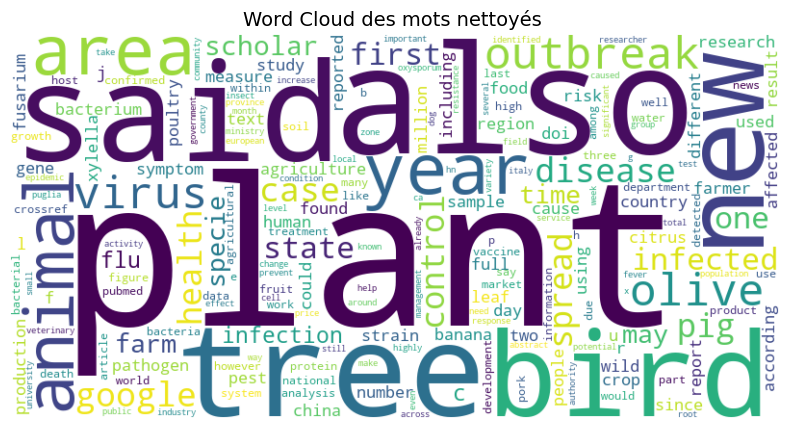

In [45]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Fusionnons tous les tokens dans une liste 

all_tokens = [token for tokens in final_data["tokens_clean"] for token in tokens]

# Calcul de la fréquence des mots 
token_counts = Counter(all_tokens)

# Affichage du word_cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200
).generate_from_frequencies(token_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud des mots nettoyés ", fontsize=14)
plt.show()


### Sauvegarde de ce jeu de données pour nos classifications 


In [55]:
final_data = final_data[["text", "tokens_clean", "text_clean", "type_article", "thematique"]]

In [56]:
final_data.to_csv("data/data_classification_2.csv", index=False)

In [57]:
final_data.head()

,text,tokens_clean,text_clean,type_article,thematique
0,Microbial Community Composition Associated wit...,"[microbial, community, composition, associated...",microbial community composition associated pot...,VS,SV
1,Plant Pathogenic and Endophytic Colletotrichum...,"[plant, pathogenic, endophytic, colletotrichum...",plant pathogenic endophytic colletotrichum fru...,VS,SV
2,Lethal Bronzing: What you should know about th...,"[lethal, bronzing, know, disease, turn, palm, ...",lethal bronzing know disease turn palm tree br...,VS,SV
3,Leaffooted Bug Damage in Almond Orchards Leaff...,"[leaffooted, bug, damage, almond, orchard, lea...",leaffooted bug damage almond orchard leaffoote...,VS,SV
4,Kebbi govt battles mysterious disease affectin...,"[kebbi, govt, battle, mysterious, disease, aff...",kebbi govt battle mysterious disease affecting...,VS,SV


In [14]:
import pandas as pd 
data = pd.read_csv("data/data_classification_2.csv", keep_default_na=False)

### Appliquons TF-IDF et XGBOOST 

Car cette approche qui avait bien fonctionné dans nos expérimentations 

Nous allons utiliser les indices sauvegardés pour spliter nos données en 3

[0]	train-logloss:0.29589	eval-logloss:0.29890
[1]	train-logloss:0.27148	eval-logloss:0.27545
[2]	train-logloss:0.25265	eval-logloss:0.25953
[3]	train-logloss:0.23572	eval-logloss:0.24434
[4]	train-logloss:0.22112	eval-logloss:0.23101
[5]	train-logloss:0.21010	eval-logloss:0.22005
[6]	train-logloss:0.19758	eval-logloss:0.20809
[7]	train-logloss:0.19030	eval-logloss:0.20184
[8]	train-logloss:0.18035	eval-logloss:0.19291
[9]	train-logloss:0.17188	eval-logloss:0.18514
[10]	train-logloss:0.16378	eval-logloss:0.17734
[11]	train-logloss:0.15611	eval-logloss:0.16951
[12]	train-logloss:0.14924	eval-logloss:0.16346
[13]	train-logloss:0.14300	eval-logloss:0.15773
[14]	train-logloss:0.13729	eval-logloss:0.15265
[15]	train-logloss:0.13150	eval-logloss:0.14775
[16]	train-logloss:0.12647	eval-logloss:0.14297
[17]	train-logloss:0.12108	eval-logloss:0.13787
[18]	train-logloss:0.11656	eval-logloss:0.13414
[19]	train-logloss:0.11265	eval-logloss:0.13025
[20]	train-logloss:0.10847	eval-logloss:0.12656
[2

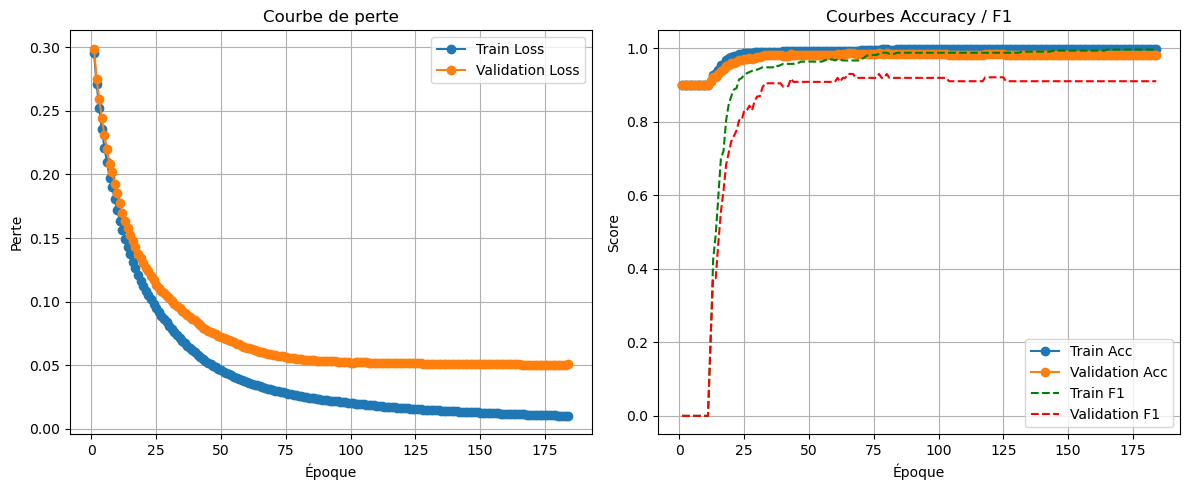

=== Rapport de classification (TF-IDF + XGBoost) sur les données de test ===
              precision    recall  f1-score   support

         NVS       0.99      1.00      0.99       202
          VS       1.00      0.87      0.93        23

    accuracy                           0.99       225
   macro avg       0.99      0.93      0.96       225
weighted avg       0.99      0.99      0.99       225



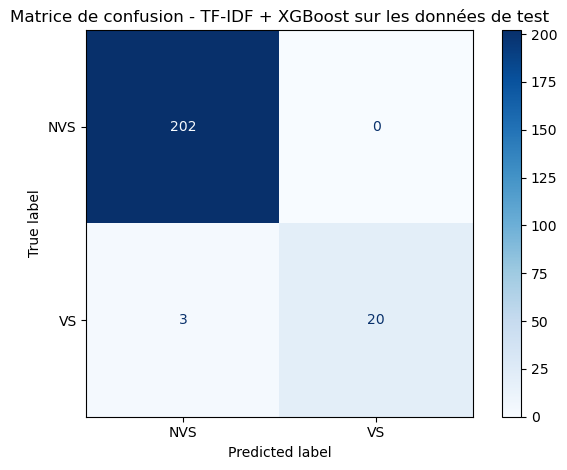

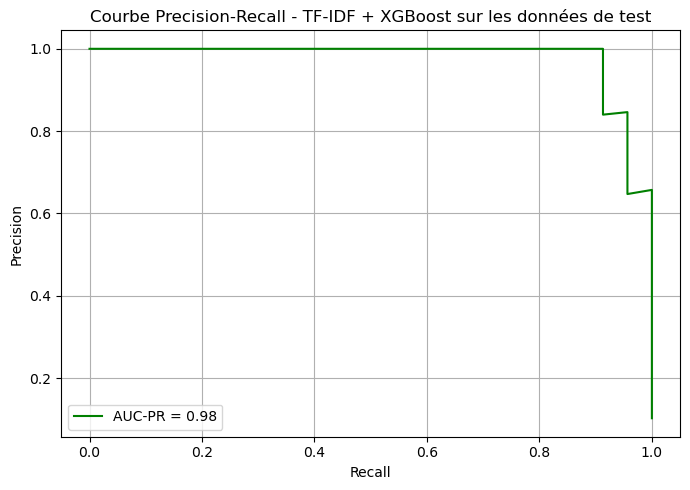

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    average_precision_score
)
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib
from sklearn.metrics import accuracy_score, f1_score
import os, joblib
import numpy as np

idx_train = np.load("splits_idx_train.npy")
idx_val   = np.load("splits_idx_val.npy")
idx_test  = np.load("splits_idx_test.npy")

# === 1. Données
X = data["text_clean"].astype(str).to_numpy()
y = data["type_article"].to_numpy()

# Encodage binaire (NVS = 0, VS = 1)
le = LabelEncoder()
y_enc = le.fit_transform(y)

# === 2. Split train / temp
X_train_texts, X_val_texts, X_test_texts = X[idx_train], X[idx_val], X[idx_test]
y_train, y_val, y_test = y_enc[idx_train], y_enc[idx_val], y_enc[idx_test]



# === 4. TF-IDF Vectorisation
vec = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = vec.fit_transform(X_train_texts)
X_val_vec   = vec.transform(X_val_texts)
X_test_vec  = vec.transform(X_test_texts)

# === 5. Modèle XGBoost avec early stopping


# Convertir en DMatrix, forme optimisée pour le modèle xgboost
dtrain = xgb.DMatrix(X_train_vec, label=y_train)
dval = xgb.DMatrix(X_val_vec, label=y_val)
dtest = xgb.DMatrix(X_test_vec)

# Paramètres du modèle
params = {
    "objective": "binary:logistic", # classification binaire
    "eval_metric": "logloss", # on regarde le logarithme de l'erreur 
    "max_depth": 5, # profondeur d'un arbre de la forêt
    "eta": 0.05, # taux d'apprentissage
    "subsample": 0.8, # taux d'échantillonnage 
    "colsample_bytree": 0.8,
    "seed": 42
}

# Initialisation du dictionnaire pour stocker les métriques
evals_result = {}

# Entraînement avec early stopping
watchlist = [(dtrain, "train"), (dval, "eval")]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000, # les arbres sont ajoutés de manière itérative, maintenant si l'apprentissage n'évolue pas on ajoute plus d'arbre
    evals=watchlist,
    early_stopping_rounds=10,
    evals_result=evals_result,
    verbose_eval=True
)

# === Courbes d'apprentissage (loss, accuracy, f1) ===
train_loss = evals_result['train']['logloss']
val_loss = evals_result['eval']['logloss']

# On calcule manuellement accuracy et f1 à chaque étape
train_acc, val_acc, train_f1, val_f1 = [], [], [], []

for i in range(len(train_loss)):
    # Prédictions train et val à l'itération i
    y_train_pred = (bst.predict(dtrain, iteration_range=(0, i+1)) >= 0.5).astype(int)
    y_val_pred = (bst.predict(dval, iteration_range=(0, i+1)) >= 0.5).astype(int)

    # Accuracies
    train_acc.append(accuracy_score(y_train, y_train_pred))
    val_acc.append(accuracy_score(y_val, y_val_pred))

    # F1 scores
    train_f1.append(f1_score(y_train, y_train_pred))
    val_f1.append(f1_score(y_val, y_val_pred))


# Affichage des courbes 
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# --- Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss", marker="o")
plt.plot(epochs, val_loss, label="Validation Loss", marker="o")
plt.xlabel("Époque")
plt.ylabel("Perte")
plt.title("Courbe de perte")
plt.legend()
plt.grid(True)

# --- Courbes Accuracy et F1
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Train Acc", marker="o")
plt.plot(epochs, val_acc, label="Validation Acc", marker="o")
plt.plot(epochs, train_f1, label="Train F1", linestyle="--", color="green")
plt.plot(epochs, val_f1, label="Validation F1", linestyle="--", color="red")
plt.xlabel("Époque")
plt.ylabel("Score")
plt.title("Courbes Accuracy / F1")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



# Prédiction sur les données de test
y_scores = bst.predict(dtest)
y_pred = (y_scores >= 0.5).astype(int)


os.makedirs("models", exist_ok=True)  # crée le dossier si absent

bst.save_model("models/sbert_xgb.json")  # ou best_modele_melange.json si tu veux
joblib.dump(le, "models/label_encoder.pkl")


# Sauvegarde du modèle 
bst.save_model("models/best_modele_melange.json")

# Sauvegarde du vectorizer 

joblib.dump(vec, "models/vectorizer_melange.pkl")

# Rapport
print("=== Rapport de classification (TF-IDF + XGBoost) sur les données de test ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues")
plt.title("Matrice de confusion - TF-IDF + XGBoost sur les données de test")
plt.tight_layout()
plt.show()

# Courbe AUC-PR
precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_pr = average_precision_score(y_test, y_scores)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.2f}", color="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe Precision-Recall - TF-IDF + XGBoost sur les données de test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Remarque 

Les performances ne sont plus vraiment pareilles que ce qu'on avait eu dans nos expérimentations mais ces résultats montrent tout de même que cette méthode fonctionne bien au vu de son AUC-PR. 

#### Cause possibles de ce changement 
- La reproductibilité de la sélection dans les articles NVS peut ne pas être respectée de manière stricte 

### Essayons de faire une recherche des features qui permettent à ce modèle de classer un article comme étant VS. 

Nous devons extraire les poids des feautures depuis le modèle, le modèle xgboost attribue des poids aux features, ici ces features correspondent aux n-grammes de notre vectorizer tf-idf

In [21]:
# Récupérer les scores d'importance des features (TF-IDF)
importance_scores = bst.get_score(importance_type='weight')  # ou 'gain' pour l'impact moyen sur la perte

# Map features index to their names
feature_names = vec.get_feature_names_out()

# Convertir les clés de type 'f123' -> index entier
feature_importances = {
    feature_names[int(k[1:])]: v for k, v in importance_scores.items()
}

# Trier par importance décroissante
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Afficher les 20 mots les plus importants
print("Top 20 mots les plus influents (poids) :")
for word, score in sorted_features[:20]:
    print(f"{word} : {score}")


Top 20 mots les plus influents (poids) :
disease : 118.0
mysterious : 107.0
unknown : 71.0
mystery : 52.0
said : 30.0
block : 29.0
could : 28.0
may : 26.0
new : 25.0
also : 22.0
target : 22.0
found : 17.0
using : 17.0
group : 16.0
illness : 16.0
need : 15.0
reported : 15.0
risk : 14.0
certain : 13.0
pest : 13.0


### Visualisation graphique

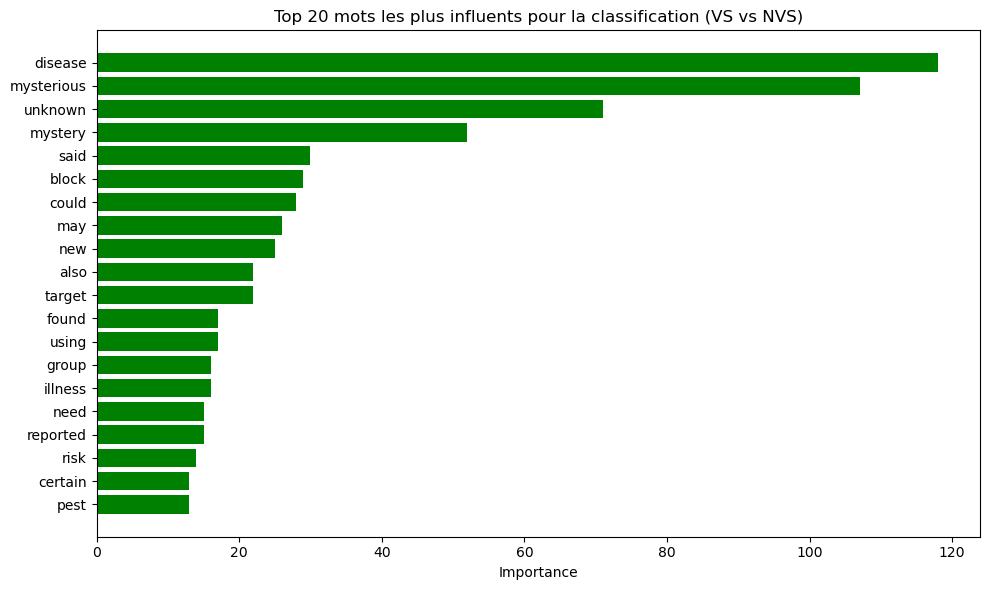

In [17]:
import matplotlib.pyplot as plt

top_words = sorted_features[:20]
words, scores = zip(*top_words)

plt.figure(figsize=(10, 6))
plt.barh(words[::-1], scores[::-1], color="green")
plt.xlabel("Importance")
plt.title("Top 20 mots les plus influents pour la classification (VS vs NVS)")
plt.tight_layout()
plt.show()


## Test

#### Formons deux phrases à partir de ces mots, nettoyons ces phrases avec notre fonction de nettoyage puis appliquons une prédiction en affichant les scores de proba

In [20]:
# =========================
# Inference TF-IDF + XGBoost (Booster)
# =========================
import os, re, joblib, numpy as np
from typing import List, Tuple
import xgboost as xgb

# --- chemins (compatibles avec ton entraînement) ---
SAVE_DIR = "models"
VEC_PATH = os.path.join(SAVE_DIR, "vectorizer_melange.pkl")   # <- tu l'as sauvegardé ainsi
LE_PATH  = os.path.join(SAVE_DIR, "label_encoder.pkl")
XGB_BOOSTER_PATH = os.path.join(SAVE_DIR, "best_modele_melange.json")  # modèle final

# =========================
# Nettoyage identique à l'entraînement
# =========================
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from string import punctuation

nltk.download("punkt", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)
nltk.download("stopwords", quiet=True)

_stop_words = set(stopwords.words("english"))
_lemmatizer = WordNetLemmatizer()
_custom_stopwords = {"et", "al"}  # comme à l'entraînement

def nettoyer_texte(texte: str) -> str:
    tokens = word_tokenize(str(texte))
    out = []
    for tok in tokens:
        tok = tok.lower()
        tok = re.sub(r"\s+", "", tok)
        tok = re.sub(r"[^a-zàâçéèêëîïôûùüÿñæœ]", "", tok)  # même regex que train
        if tok and tok not in _stop_words and tok not in punctuation and tok not in _custom_stopwords:
            tok = _lemmatizer.lemmatize(tok)
            out.append(tok)
    return " ".join(out)

# =========================
# Chargements
# =========================
if not os.path.isfile(VEC_PATH):
    raise FileNotFoundError(f"Vectorizer introuvable: {VEC_PATH}")
if not os.path.isfile(LE_PATH):
    raise FileNotFoundError(f"LabelEncoder introuvable: {LE_PATH}")
if not os.path.isfile(XGB_BOOSTER_PATH):
    raise FileNotFoundError(f"Modèle XGBoost introuvable: {XGB_BOOSTER_PATH}")

vec = joblib.load(VEC_PATH)
le  = joblib.load(LE_PATH)
classes = list(le.classes_)             # ex: ["NVS", "VS"]

booster = xgb.Booster()
booster.load_model(XGB_BOOSTER_PATH)

# =========================
# Prédiction
# =========================
def predict_tfidf_xgb(
    texts: List[str],
    clean: bool = True
) -> Tuple[List[str], np.ndarray, List[str]]:
    """
    Retourne:
      - texts_used: textes (nettoyés ou bruts) passés au vectorizer
      - probs: array (N, num_classes) ordonné comme 'classes'
      - labels_pred: classes argmax
    """
    texts_used = [nettoyer_texte(t) if clean else str(t) for t in texts]

    X = vec.transform(texts_used)
    dtest = xgb.DMatrix(X)

    # Booster binaire -> proba de la classe "1"
    score_pos = booster.predict(dtest)  # shape (N,)
    # On place cette proba au bon indice ("VS"), le complément au reste ("NVS")
    if len(classes) != 2:
        raise ValueError("Ce script suppose une classification binaire (NVS/VS).")

    probs = np.zeros((len(texts), 2), dtype=float)
    try:
        vs_idx = classes.index("VS")
        nvs_idx = 1 - vs_idx
    except ValueError:
        # Si classes sont ["0","1"] par ex., on suppose que 1 == positif
        vs_idx = classes.index("1") if "1" in classes else 1
        nvs_idx = 1 - vs_idx

    probs[:, vs_idx]  = score_pos
    probs[:, nvs_idx] = 1.0 - score_pos

    pred_idx = probs.argmax(axis=1)
    labels_pred = [classes[i] for i in pred_idx]
    return texts_used, probs, labels_pred

def print_predictions(texts: List[str], probs: np.ndarray, labels_pred: List[str]):
    for i, txt in enumerate(texts):
        print("\n" + "-"*90)
        print(f"Texte : {txt}")
        print(f"-> Classe prédite : {labels_pred[i]}")
        order = np.argsort(-probs[i])
        for j in order:
            print(f"  P({classes[j]}) = {probs[i, j]:.4f}")

def classify_tfidf_xgb(texts: List[str], clean: bool = True):
    texts_used, probs, labels = predict_tfidf_xgb(texts, clean=clean)
    print_predictions(texts, probs, labels)
    return texts_used, probs, labels

# === Exemples de test ===
phrases_test = [
    "An unusual illness was detected among domestic animals, with authorities reporting several instances of an unclassified sickness in the region.",
    "The municipality revealed plans for a new public park in the city center, aiming to draw more tourists and enhance the urban landscape."
]

# IMPORTANT : tu as entraîné TF-IDF sur "text_clean" -> garde clean=True ici
_ = classify_tfidf_xgb(phrases_test, clean=True)



------------------------------------------------------------------------------------------
Texte : An unusual illness was detected among domestic animals, with authorities reporting several instances of an unclassified sickness in the region.
-> Classe prédite : NVS
  P(NVS) = 0.9967
  P(VS) = 0.0033

------------------------------------------------------------------------------------------
Texte : The municipality revealed plans for a new public park in the city center, aiming to draw more tourists and enhance the urban landscape.
-> Classe prédite : NVS
  P(NVS) = 0.9996
  P(VS) = 0.0004


### Commentaire

Le terme *desease* semble avoir une très grande influence sur la prédiction du type de l'article mais lorqu'on le met seule dans une phrase, ce n'est pas suffisant pour dire que l'article parle de veille syndromique 

### Essayons d'appliquer la suppression des noms de maladie dans les articles et reprennons la classification et le test 

In [23]:
NOMS_MALADIE = [
    "fusarium oxysporum tropical", "hlb", "xylella fastidiosa", "dengue",
    "african swine fever", "avian influenza", "bluetongue",
    "classical swine fever", "foot and mouth disease", "lumpy skin disease",
    "peste des petits ruminants", "schmallengberg virus", "chikungunya", "cholera",
    "coronavirus", "cwd", "disease", "distemper", "echinococcus", "eee", "ehv",
    "fungus", "legionella", "mad cow", "newcastle", "parvovirus", "rabies",
    "rhd", "schmallenberg virus", "suspicion", "unknown",
    "vesicular stomatitis", "west nile", "zika"
]

MALADIE_PATTERN = re.compile("|".join(map(re.escape, NOMS_MALADIE)), flags=re.IGNORECASE)
URL_PATTERN = re.compile(r'http\S+|www\S+|<a .*?>|</a>|<.*?>', flags=re.IGNORECASE)


def supprimer_maladie(texte):
    if not isinstance(texte, str):
        return ""
    texte = URL_PATTERN.sub(" ", texte)
    texte = MALADIE_PATTERN.sub(" ", texte)
    return texte


In [25]:
data["text"] = data["text"].apply(supprimer_maladie)

data["tokens_clean"] = data["text"].apply(nettoyer_texte)

data["text_clean"] = data["tokens_clean"].apply(lambda tokens: " ".join(tokens))

On relance TF-IDF et XG-BOOST

[0]	train-logloss:0.30855	eval-logloss:0.30865
[1]	train-logloss:0.28729	eval-logloss:0.29015
[2]	train-logloss:0.26967	eval-logloss:0.27470
[3]	train-logloss:0.25564	eval-logloss:0.26322
[4]	train-logloss:0.24774	eval-logloss:0.25649
[5]	train-logloss:0.23637	eval-logloss:0.24586
[6]	train-logloss:0.22648	eval-logloss:0.23793
[7]	train-logloss:0.21807	eval-logloss:0.23008
[8]	train-logloss:0.20948	eval-logloss:0.22359
[9]	train-logloss:0.20216	eval-logloss:0.21875
[10]	train-logloss:0.19502	eval-logloss:0.21330
[11]	train-logloss:0.19025	eval-logloss:0.21024
[12]	train-logloss:0.18475	eval-logloss:0.20739
[13]	train-logloss:0.17961	eval-logloss:0.20328
[14]	train-logloss:0.17486	eval-logloss:0.20013
[15]	train-logloss:0.16966	eval-logloss:0.19637
[16]	train-logloss:0.16516	eval-logloss:0.19391
[17]	train-logloss:0.16122	eval-logloss:0.19084
[18]	train-logloss:0.15704	eval-logloss:0.18814
[19]	train-logloss:0.15277	eval-logloss:0.18549
[20]	train-logloss:0.14877	eval-logloss:0.18305
[2

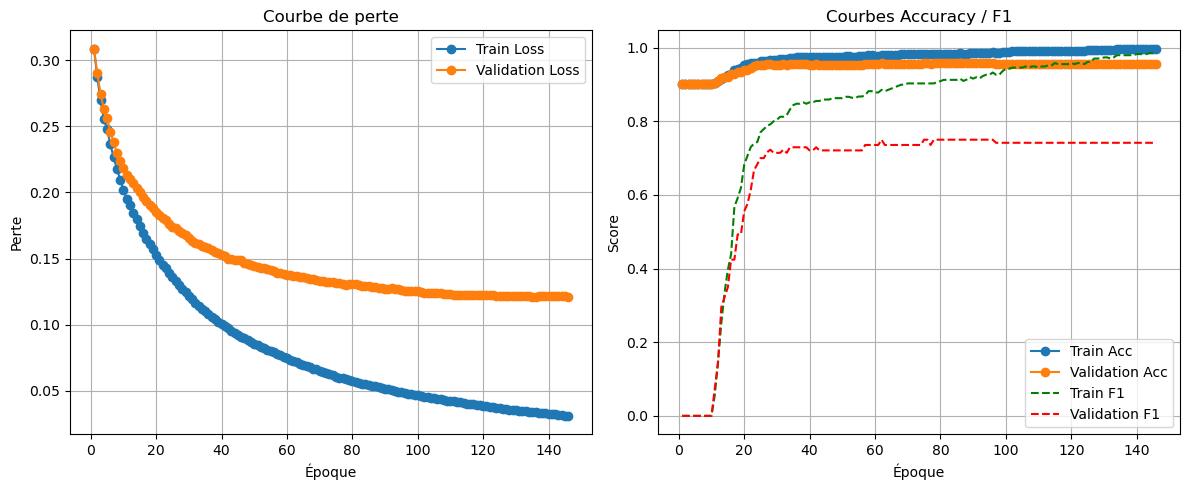

=== Rapport de classification (TF-IDF + XGBoost) sur les données de test ===
              precision    recall  f1-score   support

         NVS       0.98      0.99      0.98       202
          VS       0.90      0.78      0.84        23

    accuracy                           0.97       225
   macro avg       0.94      0.89      0.91       225
weighted avg       0.97      0.97      0.97       225



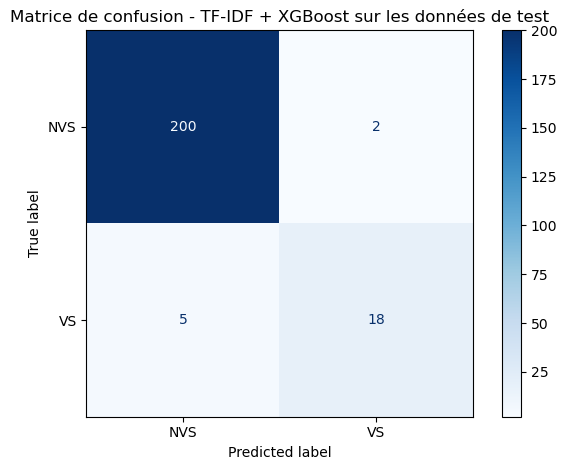

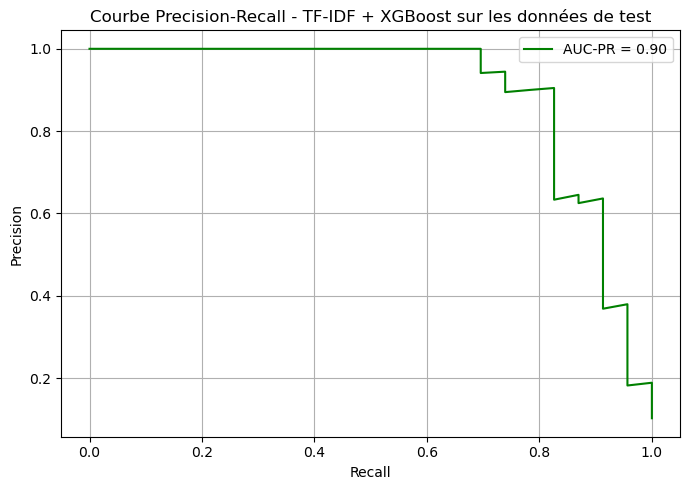

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    average_precision_score
)
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib
from sklearn.metrics import accuracy_score, f1_score
import os, joblib


# === 1. Données
X = data["text_clean"]
y = data["type_article"]

# Encodage binaire (NVS = 0, VS = 1)
le = LabelEncoder()
y_enc = le.fit_transform(y)

# === 2. Split train / temp
X_train_texts, X_temp_texts, y_train, y_temp = train_test_split(
    X, y_enc, test_size=0.3, stratify=y_enc, random_state=42
)

# === 3. Split temp → validation / test
X_val_texts, X_test_texts, y_val, y_test = train_test_split(
    X_temp_texts, y_temp, test_size=0.3, stratify=y_temp, random_state=42
)

# === 4. TF-IDF Vectorisation
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train_texts)
X_val_vec = vectorizer.transform(X_val_texts)
X_test_vec = vectorizer.transform(X_test_texts)

# === 5. Modèle XGBoost avec early stopping


# Convertir en DMatrix, forme optimisée pour le modèle xgboost
dtrain = xgb.DMatrix(X_train_vec, label=y_train)
dval = xgb.DMatrix(X_val_vec, label=y_val)
dtest = xgb.DMatrix(X_test_vec)

# Paramètres du modèle
params = {
    "objective": "binary:logistic", # classification binaire
    "eval_metric": "logloss", # on regarde le logarithme de l'erreur 
    "max_depth": 5, # profondeur d'un arbre de la forêt
    "eta": 0.05, # taux d'apprentissage
    "subsample": 0.8, # taux d'échantillonnage 
    "colsample_bytree": 0.8,
    "seed": 42
}

# Initialisation du dictionnaire pour stocker les métriques
evals_result = {}

# Entraînement avec early stopping
watchlist = [(dtrain, "train"), (dval, "eval")]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000, # les arbres sont ajoutés de manière itérative, maintenant si l'apprentissage n'évolue pas on ajoute plus d'arbre
    evals=watchlist,
    early_stopping_rounds=10,
    evals_result=evals_result,
    verbose_eval=True
)

# === Courbes d'apprentissage (loss, accuracy, f1) ===
train_loss = evals_result['train']['logloss']
val_loss = evals_result['eval']['logloss']

# On calcule manuellement accuracy et f1 à chaque étape
train_acc, val_acc, train_f1, val_f1 = [], [], [], []

for i in range(len(train_loss)):
    # Prédictions train et val à l'itération i
    y_train_pred = (bst.predict(dtrain, iteration_range=(0, i+1)) >= 0.5).astype(int)
    y_val_pred = (bst.predict(dval, iteration_range=(0, i+1)) >= 0.5).astype(int)

    # Accuracies
    train_acc.append(accuracy_score(y_train, y_train_pred))
    val_acc.append(accuracy_score(y_val, y_val_pred))

    # F1 scores
    train_f1.append(f1_score(y_train, y_train_pred))
    val_f1.append(f1_score(y_val, y_val_pred))


# Affichage des courbes 
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# --- Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss", marker="o")
plt.plot(epochs, val_loss, label="Validation Loss", marker="o")
plt.xlabel("Époque")
plt.ylabel("Perte")
plt.title("Courbe de perte")
plt.legend()
plt.grid(True)

# --- Courbes Accuracy et F1
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Train Acc", marker="o")
plt.plot(epochs, val_acc, label="Validation Acc", marker="o")
plt.plot(epochs, train_f1, label="Train F1", linestyle="--", color="green")
plt.plot(epochs, val_f1, label="Validation F1", linestyle="--", color="red")
plt.xlabel("Époque")
plt.ylabel("Score")
plt.title("Courbes Accuracy / F1")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



# Prédiction sur les données de test
y_scores = bst.predict(dtest)
y_pred = (y_scores >= 0.5).astype(int)


os.makedirs("models", exist_ok=True)  # crée le dossier si absent

bst.save_model("models/sbert_xgb.json")  # ou best_modele_melange.json si tu veux
joblib.dump(le, "models/label_encoder.pkl")


# Sauvegarde du modèle 
bst.save_model("models/best_modele_melange.json")

# Sauvegarde du vectorizer 

joblib.dump(vectorizer, "models/vectorizer_melange.pkl")

# Rapport
print("=== Rapport de classification (TF-IDF + XGBoost) sur les données de test ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues")
plt.title("Matrice de confusion - TF-IDF + XGBoost sur les données de test")
plt.tight_layout()
plt.show()

# Courbe AUC-PR
precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_pr = average_precision_score(y_test, y_scores)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.2f}", color="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe Precision-Recall - TF-IDF + XGBoost sur les données de test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Commentaire

Les performances sont réduites, peut-être devons nous voir en cela une réduction du surapprentissage? 

Voyons maintenant les mots que ce modèle utilise pour donner VS à une classe 


In [31]:
# Récupérer les scores d'importance des features (TF-IDF)
importance_scores = bst.get_score(importance_type='weight')  # ou 'gain' pour l'impact moyen sur la perte

# Map features index to their names
feature_names = vectorizer.get_feature_names_out()

# Convertir les clés de type 'f123' -> index entier
feature_importances = {
    feature_names[int(k[1:])]: v for k, v in importance_scores.items()
}

# Trier par importance décroissante
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Afficher les 20 mots les plus importants
print("Top 20 mots les plus influents (poids) :")
for word, score in sorted_features[:20]:
    print(f"{word} : {score}")


Top 20 mots les plus influents (poids) :
mysterious : 74.0
mystery : 57.0
said : 33.0
also : 28.0
may : 22.0
pig : 21.0
flu : 20.0
case : 19.0
wildlife : 19.0
first : 18.0
health : 18.0
across : 17.0
leaf : 17.0
state : 17.0
appears : 16.0
million : 16.0
agriculture : 15.0
cause : 15.0
forest : 15.0
outbreak : 15.0


Essayons de tester notre modèle avec des phrases que nous avions définnies plus haut 

In [30]:
## les phrases 
phrases_test = [
    "A mysterious disease was reported by the group and may be a new unknown illness.",
    "The pest risk is high and this could target a certain block, said the group."
]


## Nettoyons 

phrases_tokenisees = [nettoyer_texte(phrase) for phrase in phrases_test]

## Reformater les textes 
phrases_nettoyees = [" ".join(tokens) for tokens in phrases_tokenisees]


# Vectorisation (penser à sauvegarder le vectorizer qu'on pourra charger à ce niveau)
X_test_new = vectorizer.transform(phrases_nettoyees)

## Prédictions avec xgboost
dtest_new = xgb.DMatrix(X_test_new)
y_scores_new = bst.predict(dtest_new)


## Les résultats
for i, phrase in enumerate(phrases_test):
    print(f"\nTexte : {phrase}")
    print(f"Texte nettoyé : {phrases_nettoyees[i]}")
    print(f"-> Score VS : {y_scores_new[i]:.4f}")
    print(f"-> Score NVS : {1 - y_scores_new[i]:.4f}")
    classe_predite = "VS" if y_scores_new[i] >= 0.5 else "NVS"
    print(f"-> Classe prédite : {classe_predite}")




Texte : A mysterious disease was reported by the group and may be a new unknown illness.
Texte nettoyé : mysterious disease reported group may new unknown illness
-> Score VS : 0.9531
-> Score NVS : 0.0469
-> Classe prédite : VS

Texte : The pest risk is high and this could target a certain block, said the group.
Texte nettoyé : pest risk high could target certain block said group
-> Score VS : 0.0698
-> Score NVS : 0.9302
-> Classe prédite : NVS


### Commentaire

Avec suppression des noms de maladie, nous constatons que le modèle n'arrive pas toujours à attribuer VS à la deuxième phrase malgré le fait que la phrase peut sembler utiliser les mots de la VS 

### Remplaçons la vectorisation TF-IDF avec SBERT 

Nous avons fait sur les données avec et sans nom de maladie, les meilleurs performances sont observées lorsqu'on garde les noms de maladie dans notre jeu de données (déjà elles ne sont pas en grande quantité ici)

C:\Users\stginrae.AFRIQUE-TP02\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

[0]	train-logloss:0.65475	train-aucpr:0.66145	eval-logloss:0.66032	eval-aucpr:0.41878
[1]	train-logloss:0.62337	train-aucpr:0.80270	eval-logloss:0.63572	eval-aucpr:0.44251
[2]	train-logloss:0.59246	train-aucpr:0.88027	eval-logloss:0.60994	eval-aucpr:0.47032
[3]	train-logloss:0.56453	train-aucpr:0.93287	eval-logloss:0.58559	eval-aucpr:0.53885
[4]	train-logloss:0.53755	train-aucpr:0.94331	eval-logloss:0.56266	eval-aucpr:0.59536
[5]	train-logloss:0.51130	train-aucpr:0.96853	eval-logloss:0.53810	eval-aucpr:0.62541
[6]	train-logloss:0.48820	train-aucpr:0.97424	eval-logloss:0.51880	eval-aucpr:0.64113
[7]	train-logloss:0.46806	train-aucpr:0.98004	eval-logloss:0.50431	eval-aucpr:0.63086
[8]	train-logloss:0.44807	train-aucpr:0.98313	eval-logloss:0.48669	eval-aucpr:0.66235
[9]	train-logloss:0.42853	train-aucpr:0.98640	eval-logloss:0.47088	eval-aucpr:0.66033
[10]	train-logloss:0.41137	train-aucpr:0.98656	eval-logloss:0.45584	eval-aucpr:0.67366
[11]	train-logloss:0.39561	train-aucpr:0.98704	eval-l

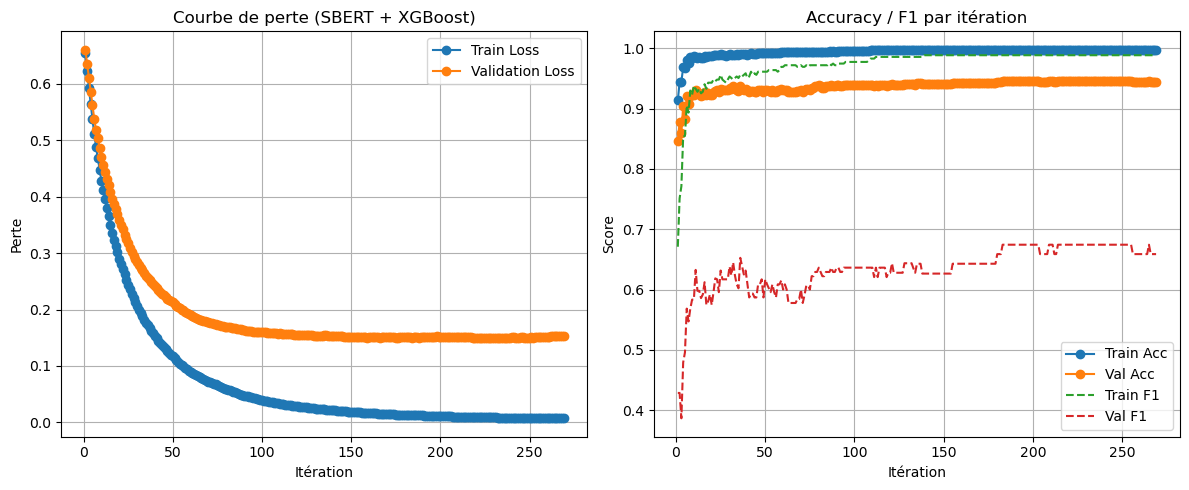

=== Rapport (SBERT + XGBoost) - Test ===
              precision    recall  f1-score   support

         NVS       0.95      0.99      0.97       202
          VS       0.86      0.52      0.65        23

    accuracy                           0.94       225
   macro avg       0.90      0.76      0.81       225
weighted avg       0.94      0.94      0.94       225



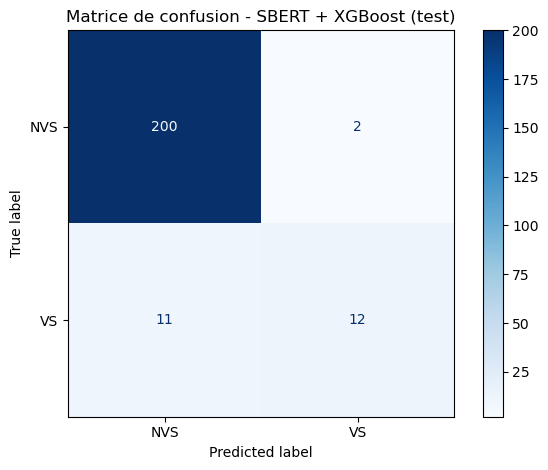

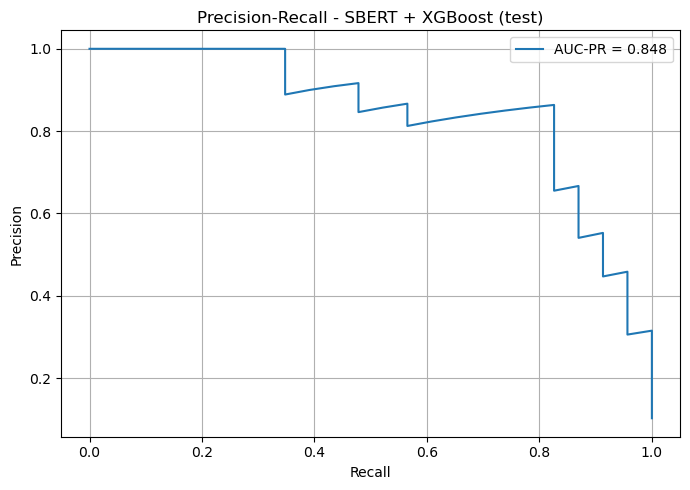

['models/sbert_meta.pkl']

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    average_precision_score,
    accuracy_score,
    f1_score,
)
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import joblib
from sentence_transformers import SentenceTransformer
import os

# === 1. Données
X = data["text_clean"]
y = data["type_article"]

# Encodage binaire (NVS = 0, VS = 1)
le = LabelEncoder()
y_enc = le.fit_transform(y)

# === 2. Split train / temp
X_train_texts, X_temp_texts, y_train, y_temp = train_test_split(
    X, y_enc, test_size=0.3, stratify=y_enc, random_state=42
)

# === 3. Split temp → validation / test
X_val_texts, X_test_texts, y_val, y_test = train_test_split(
    X_temp_texts, y_temp, test_size=0.3, stratify=y_temp, random_state=42
)

# === 4. SBERT embeddings (remplace TF-IDF)
sbert_name = "all-MiniLM-L6-v2"
sbert = SentenceTransformer(sbert_name)

def embed(texts):
    # Retourne un np.array (n_samples, 384)
    return sbert.encode(
        texts.tolist() if hasattr(texts, "tolist") else texts,
        batch_size=64,
        convert_to_numpy=True,
        normalize_embeddings=False,   # mettre True si vous souhaitez L2-normaliser
        show_progress_bar=True,
    )

X_train_vec = embed(X_train_texts)
X_val_vec   = embed(X_val_texts)
X_test_vec  = embed(X_test_texts)

# === 5. XGBoost sur embeddings SBERT (avec early stopping)
# Gestion du déséquilibre éventuel
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / max(pos, 1)

dtrain = xgb.DMatrix(X_train_vec, label=y_train)
dval   = xgb.DMatrix(X_val_vec,   label=y_val)
dtest  = xgb.DMatrix(X_test_vec)

params = {
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "aucpr"],  # on suit loss + AUC-PR
    "max_depth": 5,
    "eta": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42,
    "scale_pos_weight": scale_pos_weight,  # utile si classes déséquilibrées
}

evals_result = {}
watchlist = [(dtrain, "train"), (dval, "eval")]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=watchlist,
    early_stopping_rounds=20,
    evals_result=evals_result,
    verbose_eval=True,
)

# === Courbes d'apprentissage (loss + acc/f1 par itération)
train_loss = evals_result["train"]["logloss"]
val_loss   = evals_result["eval"]["logloss"]

train_acc, val_acc, train_f1, val_f1 = [], [], [], []
for i in range(len(train_loss)):
    # Prédictions à l'itération i
    y_train_pred = (bst.predict(dtrain, iteration_range=(0, i+1)) >= 0.5).astype(int)
    y_val_pred   = (bst.predict(dval,   iteration_range=(0, i+1)) >= 0.5).astype(int)

    train_acc.append(accuracy_score(y_train, y_train_pred))
    val_acc.append(accuracy_score(y_val, y_val_pred))
    train_f1.append(f1_score(y_train, y_train_pred))
    val_f1.append(f1_score(y_val, y_val_pred))

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss", marker="o")
plt.plot(epochs, val_loss,   label="Validation Loss", marker="o")
plt.xlabel("Itération")
plt.ylabel("Perte")
plt.title("Courbe de perte (SBERT + XGBoost)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Train Acc", marker="o")
plt.plot(epochs, val_acc,   label="Val Acc", marker="o")
plt.plot(epochs, train_f1,  label="Train F1", linestyle="--")
plt.plot(epochs, val_f1,    label="Val F1", linestyle="--")
plt.xlabel("Itération")
plt.ylabel("Score")
plt.title("Accuracy / F1 par itération")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# === Test final
y_scores = bst.predict(dtest)                 # proba VS
y_pred   = (y_scores >= 0.5).astype(int)

print("=== Rapport (SBERT + XGBoost) - Test ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues")
plt.title("Matrice de confusion - SBERT + XGBoost (test)")
plt.tight_layout()
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_pr = average_precision_score(y_test, y_scores)
plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall - SBERT + XGBoost (test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Sauvegardes
os.makedirs("models", exist_ok=True)
bst.save_model("models/sbert_xgb.json")              # modèle XGBoost
joblib.dump(le, "models/label_encoder.pkl")          # label encoder
sbert.save("models/sbert_all-MiniLM-L6-v2")          # poids + config SBERT
joblib.dump({"sbert_name": sbert_name}, "models/sbert_meta.pkl")  # méta pour rechargement


In [23]:
import joblib
import xgboost as xgb
from sentence_transformers import SentenceTransformer
import numpy as np

# --- 1) Charger les modèles entraînés ---
# Chemins à adapter si besoin
bst = xgb.Booster()
bst.load_model("models/sbert_xgb.json")              # modèle XGBoost sauvegardé
sbert = SentenceTransformer("models/sbert_all-MiniLM-L6-v2")  # SBERT sauvegardé
le = joblib.load("models/label_encoder.pkl")         # optionnel (pour les noms de classes)

# --- 2) Phrases à tester ---
phrases_test = [
    "A mysterious disease was reported by the group and may be a new unknown illness.",
    "The pest risk is high and this could target a certain block, said the group."
]

# --- 3) Nettoyage identique à l'entraînement ---
# ta fonction doit être la même que celle utilisée au train :
# elle renvoie soit une liste de tokens, soit un texte propre
def preprocess_for_inference(texts):
    cleaned = []
    for p in texts:
        tokens = nettoyer_texte(p)     # ta fonction existante
        if isinstance(tokens, list):
            cleaned.append(" ".join(tokens))
        else:
            cleaned.append(tokens)
    return cleaned

phrases_nettoyees = preprocess_for_inference(phrases_test)

# --- 4) Embeddings SBERT (mêmes options qu’au train) ---
X_test_new = sbert.encode(
    phrases_nettoyees,
    batch_size=64,
    convert_to_numpy=True,
    normalize_embeddings=False,   # gardez la même valeur qu’au training
    show_progress_bar=False
)

# --- 5) Prédictions XGBoost ---
dtest_new = xgb.DMatrix(X_test_new)
y_scores_new = bst.predict(dtest_new)  # proba de la classe positive (VS si 1=VS)
y_pred_new = (y_scores_new >= 0.5).astype(int)  # seuil 0.5 (modifie si tu as un seuil optimal)

# --- 6) Affichage ---
classes = list(le.classes_) if le is not None else ["NVS","VS"]  # adapte si besoin
for i, phrase in enumerate(phrases_test):
    print(f"\nTexte : {phrase}")
    print(f"Texte nettoyé : {phrases_nettoyees[i]}")
    print(f"-> Score VS : {y_scores_new[i]:.4f}")
    print(f"-> Score NVS : {1 - y_scores_new[i]:.4f}")
    idx = y_pred_new[i]
    # si tes labels encodés sont (NVS=0, VS=1), ceci renverra bien VS/NVS
    print(f"-> Classe prédite : {classes[idx] if len(classes)==2 else ('VS' if idx==1 else 'NVS')}")



Texte : A mysterious disease was reported by the group and may be a new unknown illness.
Texte nettoyé : mysterious disease reported group may new unknown illness
-> Score VS : 0.9766
-> Score NVS : 0.0234
-> Classe prédite : VS

Texte : The pest risk is high and this could target a certain block, said the group.
Texte nettoyé : pest risk high could target certain block said group
-> Score VS : 0.0267
-> Score NVS : 0.9733
-> Classe prédite : NVS


### TF-IDF + XGBOOST reste meilleur jusqu'à présent même au niveau des tests sur des courtes phrases 

### Appliquons voir SBERT + MLP que nous avions appliqué à la pahse 1 du projet 

In [41]:
# =========================
# 0) Imports & seed
# =========================
import os, numpy as np, pandas as pd, torch, torch.nn as nn, torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sentence_transformers import SentenceTransformer
from torch.utils.data import Dataset, DataLoader

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# =========================
# 1) Charger tes données phase 2

df = data.copy()

# =========================
# 2) Encodage des labels + split
# =========================
le = LabelEncoder()
y = le.fit_transform(df['type_article'])
X_text = df["text_clean"].astype(str).tolist()

X_train_text, X_temp_text, y_train, y_temp = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=SEED
)
X_val_text, X_test_text, y_val, y_test = train_test_split(
    X_temp_text, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED
)

num_classes = len(le.classes_)
print("Classes:", dict(zip(range(num_classes), le.classes_)))

# =========================
# 3) Embeddings SBERT (batched)
# =========================
sbert = SentenceTransformer('all-MiniLM-L6-v2', device=str(device))

def encode_texts(texts, batch_size=256):
    embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        with torch.no_grad():
            emb = sbert.encode(batch, convert_to_numpy=True, show_progress_bar=False, batch_size=batch_size)
        embs.append(emb)
    return np.vstack(embs)

X_train_emb = encode_texts(X_train_text)
X_val_emb   = encode_texts(X_val_text)
X_test_emb  = encode_texts(X_test_text)

print("Dims:", X_train_emb.shape, X_val_emb.shape, X_test_emb.shape)  # (N, 384) pour all-MiniLM-L6-v2

# =========================
# 4) Torch Dataset / DataLoader
# =========================
class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_ds = NumpyDataset(X_train_emb, y_train)
val_ds   = NumpyDataset(X_val_emb, y_val)
test_ds  = NumpyDataset(X_test_emb, y_test)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, drop_last=False)

# =========================
# 5) Modèle (ta classe)
# =========================
class SBERTClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.classifier(x)

model = SBERTClassifier(X_train_emb.shape[1], num_classes).to(device)

# =========================
# 6) Perte pondérée (déséquilibre) + optim
# =========================
# Comme nos classes sont déséquilibrées
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
# (Optionnel) scheduler si tu veux
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# =========================
# 7) Entraînement avec early stopping (le tien)
# =========================
save_dir = "models"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "best_sbert_phase2.pt")

best_val_loss = np.inf
patience = 5
patience_counter = 0

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "train_f1": [], "val_f1": []}
num_epochs = 100

for epoch in range(num_epochs):
    # ---- Train ----
    model.train()
    y_true_train, y_pred_train = [], []
    train_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = logits.argmax(dim=1)
        y_true_train.extend(yb.detach().cpu().numpy())
        y_pred_train.extend(preds.detach().cpu().numpy())

    train_loss /= len(train_loader)
    train_acc = accuracy_score(y_true_train, y_pred_train)
    train_f1 = f1_score(y_true_train, y_pred_train, average='macro')

    # ---- Val ----
    model.eval()
    y_true_val, y_pred_val = [], []
    val_loss = 0.0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()
            preds = logits.argmax(dim=1)
            y_true_val.extend(yb.detach().cpu().numpy())
            y_pred_val.extend(preds.detach().cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = accuracy_score(y_true_val, y_pred_val)
    val_f1 = f1_score(y_true_val, y_pred_val, average='macro')

    # scheduler.step(val_loss)  # si utilisé

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["train_f1"].append(train_f1)
    history["val_f1"].append(val_f1)

    print(f"[{epoch+1:03d}/{num_epochs}] "
          f"Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f} | "
          f"Train Acc {train_acc:.4f} | Val Acc {val_acc:.4f} | "
          f"Train F1 {train_f1:.4f} | Val F1 {val_f1:.4f}")

    # Early stopping
    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping déclenché.")
            break

print("Meilleur val_loss:", round(best_val_loss, 4))

# =========================
# 8) Rechargement & Évaluation test
# =========================
# --- Rechargement des poids 
state_dict = torch.load(save_path, map_location=device, weights_only=True)
model.load_state_dict(state_dict)


model.eval()
y_true_test, y_pred_test = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        y_pred_test.extend(preds)
        y_true_test.extend(yb.numpy())

test_acc = accuracy_score(y_true_test, y_pred_test)
test_f1 = f1_score(y_true_test, y_pred_test, average='macro')
print("\n== Évaluation Test ==")
print("Accuracy:", round(test_acc, 4))
print("Macro-F1:", round(test_f1, 4))
print("\nClassification report:")
print(classification_report(y_true_test, y_pred_test, target_names=le.classes_))

print("\nMatrice de confusion:\n", confusion_matrix(y_true_test, y_pred_test))

# =========================
# 9) Sauvegardes utiles
# =========================
# Sauvegarder l'encoder (utile au déploiement)
import joblib, json
joblib.dump(le, os.path.join(save_dir, "label_encoder.joblib"))
with open(os.path.join(save_dir, "train_history.json"), "w", encoding="utf-8") as f:
    json.dump(history, f, ensure_ascii=False, indent=2)



Device: cpu
Classes: {0: 'NVS', 1: 'VS'}


C:\Users\stginrae.AFRIQUE-TP02\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Dims: (1992, 384) (249, 384) (249, 384)
[001/100] Train Loss 0.6927 | Val Loss 0.6873 | Train Acc 0.1034 | Val Acc 0.1004 | Train F1 0.0952 | Val F1 0.0912
[002/100] Train Loss 0.6861 | Val Loss 0.6811 | Train Acc 0.1411 | Val Acc 0.2048 | Train F1 0.1383 | Val F1 0.2048
[003/100] Train Loss 0.6800 | Val Loss 0.6744 | Train Acc 0.3072 | Val Acc 0.3815 | Train F1 0.2984 | Val F1 0.3606
[004/100] Train Loss 0.6726 | Val Loss 0.6667 | Train Acc 0.4880 | Val Acc 0.5743 | Train F1 0.4372 | Val F1 0.5053
[005/100] Train Loss 0.6643 | Val Loss 0.6577 | Train Acc 0.6330 | Val Acc 0.7028 | Train F1 0.5344 | Val F1 0.5891
[006/100] Train Loss 0.6560 | Val Loss 0.6475 | Train Acc 0.7189 | Val Acc 0.7711 | Train F1 0.5916 | Val F1 0.6460
[007/100] Train Loss 0.6437 | Val Loss 0.6360 | Train Acc 0.7856 | Val Acc 0.8112 | Train F1 0.6446 | Val F1 0.6840
[008/100] Train Loss 0.6339 | Val Loss 0.6234 | Train Acc 0.8243 | Val Acc 0.8394 | Train F1 0.6814 | Val F1 0.7080
[009/100] Train Loss 0.6191 | Va

In [43]:
import os
import json
import joblib
import numpy as np
import torch
import torch.nn as nn
from sentence_transformers import SentenceTransformer

# ==== 1) Paramètres / chemins ====
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "models"
MODEL_PATH = os.path.join(SAVE_DIR, "best_sbert_phase2.pt")       # state_dict uniquement
LE_PATH    = os.path.join(SAVE_DIR, "label_encoder.joblib")       # sauvegardé au train
CLASSES_JSON = os.path.join(SAVE_DIR, "classes.json")             # optionnel
SBERT_PATH = "models/sbert_all-MiniLM-L6-v2"                      # si tu l’as sauvegardé localement
# Sinon, mets le nom du modèle huggingface que tu as utilisé à l’entrainement:
# SBERT_PATH = "sentence-transformers/all-MiniLM-L6-v2"

# ==== 2) Même archi que durant le train ====
class SBERTClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.classifier(x)

# ==== 3) Charger label encoder & classes ====
le = joblib.load(LE_PATH)
classes = list(le.classes_)

# Si tu n’as pas le joblib sous la main mais un classes.json séparé :
if not classes and os.path.exists(CLASSES_JSON):
    with open(CLASSES_JSON, "r", encoding="utf-8") as f:
        classes = json.load(f)

# ==== 4) Charger SBERT ====
sbert = SentenceTransformer(SBERT_PATH, device=str(DEVICE))

# ==== 5) Reconstruire le modèle & charger les poids ====
# embedding_dim pour all-MiniLM-L6-v2 = 384 (si tu as utilisé un autre modèle, adapte)
embedding_dim = sbert.get_sentence_embedding_dimension()
num_classes = len(classes)

model = SBERTClassifier(embedding_dim, num_classes).to(DEVICE)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=True)
model.load_state_dict(state_dict)
model.eval()

# ==== 6) Prétraitement identique au train ====
# Remplace par ta vraie fonction (celle utilisée au training)
def nettoyer_texte(text: str):
    # EXEMPLE minimal — à remplacer par ta version
    return " ".join(text.lower().split())

def preprocess_for_inference(texts):
    out = []
    for p in texts:
        tokens_or_str = nettoyer_texte(p)
        if isinstance(tokens_or_str, list):
            out.append(" ".join(tokens_or_str))
        else:
            out.append(tokens_or_str)
    return out

# ==== 7) Fonction d’inférence ====
@torch.no_grad()
def predict_texts(texts, batch_size=64, normalize_embeddings=False):
    """
    - texts: liste de chaînes
    - normalize_embeddings: doit matcher la valeur utilisée à l'entraînement (False si tu n'as rien modifié)
    Retourne: probs (N, C), preds_idx (N,), preds_labels (N,)
    """
    cleaned = preprocess_for_inference(texts)
    # Encodage SBERT
    embs = sbert.encode(
        cleaned,
        batch_size=batch_size,
        convert_to_numpy=True,
        normalize_embeddings=normalize_embeddings,
        show_progress_bar=False
    )
    # Passage modèle
    xb = torch.tensor(embs, dtype=torch.float32, device=DEVICE)
    logits = model(xb)
    probs = torch.softmax(logits, dim=1).cpu().numpy()
    preds_idx = probs.argmax(axis=1)
    preds_labels = [classes[i] for i in preds_idx]
    return cleaned, probs, preds_idx, preds_labels

# ==== 8) Exemple d’utilisation ====
phrases_test = [
    "A mysterious disease was reported by the group and may be a new unknown illness.",
    "The pest disease risk is high and this could target a certain block, said the group."
]

cleaned, probs, idx, labels = predict_texts(phrases_test, batch_size=64, normalize_embeddings=False)

# Affichage
for i, p in enumerate(phrases_test):
    print(f"\nTexte : {p}")
    print(f"Texte nettoyé : {cleaned[i]}")
    # Affiche les probas par classe (ordre = le.classes_)
    for c, pr in zip(classes, probs[i]):
        print(f"  P({c}) = {pr:.4f}")
    print(f"-> Classe prédite : {labels[i]}")



Texte : A mysterious disease was reported by the group and may be a new unknown illness.
Texte nettoyé : a mysterious disease was reported by the group and may be a new unknown illness.
  P(NVS) = 0.0357
  P(VS) = 0.9643
-> Classe prédite : VS

Texte : The pest disease risk is high and this could target a certain block, said the group.
Texte nettoyé : the pest disease risk is high and this could target a certain block, said the group.
  P(NVS) = 0.6530
  P(VS) = 0.3470
-> Classe prédite : NVS


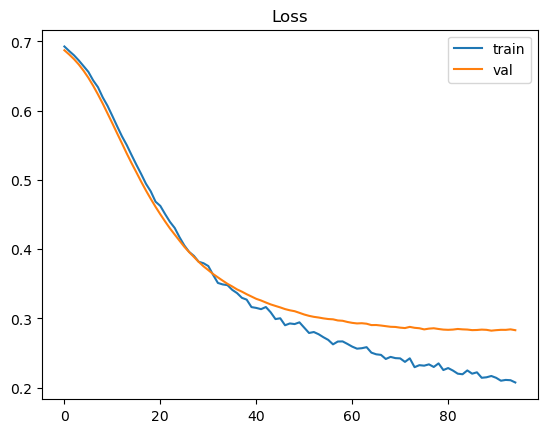

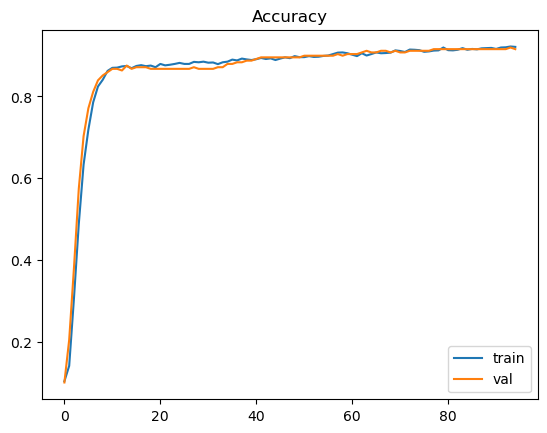

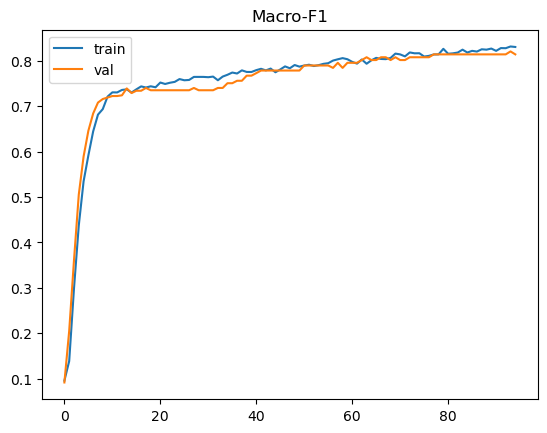

In [44]:
# Tracer les courbes d'apprentissage:
import matplotlib.pyplot as plt
plt.figure(); plt.plot(history["train_loss"]); plt.plot(history["val_loss"]); plt.title("Loss"); plt.legend(["train","val"]); plt.show()
plt.figure(); plt.plot(history["train_acc"]); plt.plot(history["val_acc"]); plt.title("Accuracy"); plt.legend(["train","val"]); plt.show()
plt.figure(); plt.plot(history["train_f1"]); plt.plot(history["val_f1"]); plt.title("Macro-F1"); plt.legend(["train","val"]); plt.show()


### Nous avons fait plusieurs entrainements ainsi que des tests, avec et sans noms de maladies, nous avons remarqué que la courbe d'apprentissage est meilleures avec le modèle TF-IDF et XG-BOOST lorsqu'on conserve les noms de maladie que nous avons (déjà nous n'avons pas tous les noms de maladie car nous avons utilisé les données nettoyées de la phase 1), c'est le mot "disease" qui 

Nous allons donc devoir conserver ce modèle pour cette deuxième phase du stage 